In [1]:
# !pip install pycaret
# !pip install gradio




In [2]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import glob
import os


In [3]:
# Define the folder path
data_folder = '/Users/dhanmoti/Desktop/Workspace/ml-ai-source-code/sg-tbill-yield/data'

# Find all CSV files in the folder
csv_files = glob.glob(os.path.join(data_folder, '*.csv'))

# Read and concatenate all files into one DataFrame
df_list = [pd.read_csv(file) for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

In [4]:
df.head()

,Issue Code,ISIN Code,Auction Date,Issue Date,Maturity Date,Auction Tenor (Month),Auction Amount (S$M),Amount Applied (S$M),Bid-to-Cover Ratio,Cut-off Yield (%),Cut-off Price,Median Yield (%),Median Price,Average Yield (%),Average Price
0,BS24101Z,SGXZ64133028,18 Jan 2024,23 Jan 2024,23 Jul 2024,6,6400,13551.553,2.12,3.70,98.155,3.60,98.205,3.11,98.449
1,BY24100T,SGXZ89281026,25 Jan 2024,30 Jan 2024,28 Jan 2025,12,4500,14372.396,3.19,3.45,96.559,3.40,96.609,3.13,96.879
2,BS24102S,SGXZ32636938,01 Feb 2024,06 Feb 2024,06 Aug 2024,6,6300,14625.066,2.32,3.54,98.235,3.21,98.399,2.63,98.689
3,BS24103H,SGXZ50304468,15 Feb 2024,20 Feb 2024,20 Aug 2024,6,6600,13519.977,2.05,3.66,98.175,3.48,98.265,3.00,98.504
4,BS24104T,SGXZ48734073,29 Feb 2024,05 Mar 2024,03 Sep 2024,6,6400,12446.564,1.94,3.80,98.105,3.50,98.255,2.95,98.529


In [5]:
# Convert date columns to datetime
df['Auction Date'] = pd.to_datetime(df['Auction Date'])
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Maturity Date'] = pd.to_datetime(df['Maturity Date'])

# Basic EDA summary
shape = df.shape
columns = df.columns.tolist()
missing = df.isnull().sum()
summary = df.describe(include='all')

# Check data types
dtypes = df.dtypes

# shape, columns, missing, dtypes, summary

In [6]:
summary

,Issue Code,ISIN Code,Auction Date,Issue Date,Maturity Date,Auction Tenor (Month),Auction Amount (S$M),Amount Applied (S$M),Bid-to-Cover Ratio,Cut-off Yield (%),Cut-off Price,Median Yield (%),Median Price,Average Yield (%),Average Price
count,662,662,662,662,662,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
unique,662,662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,BS24101Z,SGXZ64133028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,2013-07-06 05:24:06.525679872,2013-07-09 22:43:52.024169216,2013-11-29 03:33:10.332326400,4.685801,3281.268882,6658.781461,1.993066,1.347644,99.427595,0.655151,62.775347,1.191344,99.499716
min,NaN,NaN,2005-08-01 00:00:00,2005-08-04 00:00:00,2005-11-04 00:00:00,3.000000,1200.000000,2056.702000,1.320000,0.090000,96.141000,0.000000,0.000000,0.030000,96.480000
25%,NaN,NaN,2008-08-19 18:00:00,2008-08-22 18:00:00,2008-11-28 18:00:00,3.000000,2000.000000,4040.656250,1.730000,0.300000,99.237750,0.000000,0.000000,0.220000,99.277000
50%,NaN,NaN,2011-09-08 12:00:00,2011-09-11 12:00:00,2011-12-18 12:00:00,3.000000,3400.000000,6073.920500,1.940000,0.540000,99.781000,0.200000,98.604000,0.420000,99.824000
75%,NaN,NaN,2020-01-26 12:00:00,2020-01-30 06:00:00,2020-08-21 12:00:00,6.000000,3900.000000,8037.714000,2.180000,2.400000,99.915000,0.340000,99.920000,2.260000,99.938000
max,NaN,NaN,2025-07-24 00:00:00,2025-07-29 00:00:00,2026-07-28 00:00:00,12.000000,7600.000000,23272.954000,3.350000,4.400000,99.978000,4.000000,99.995000,3.770000,99.993000


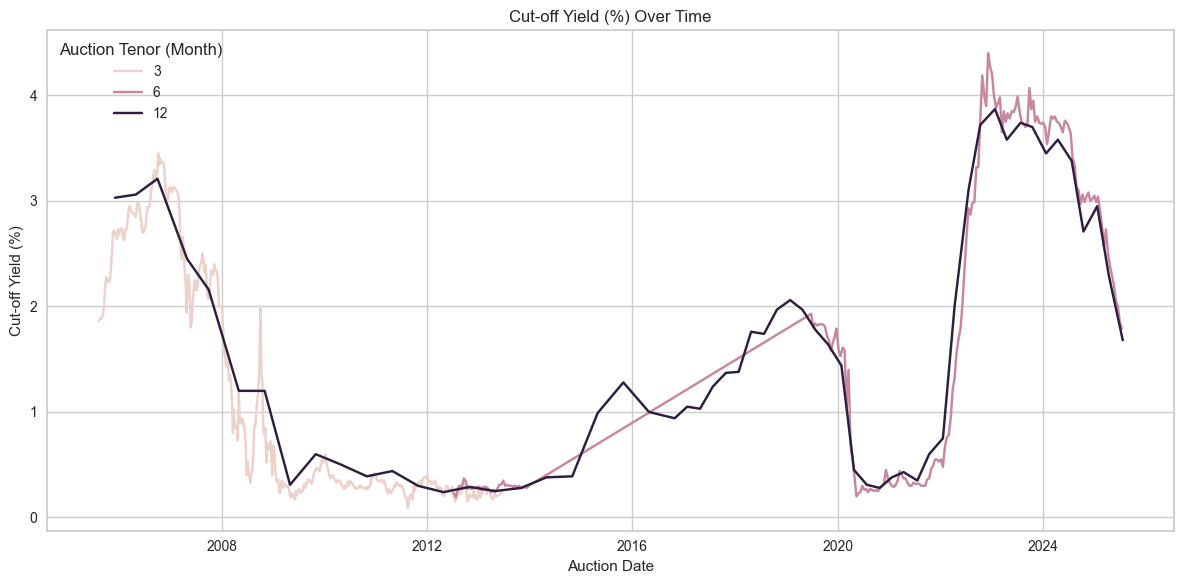

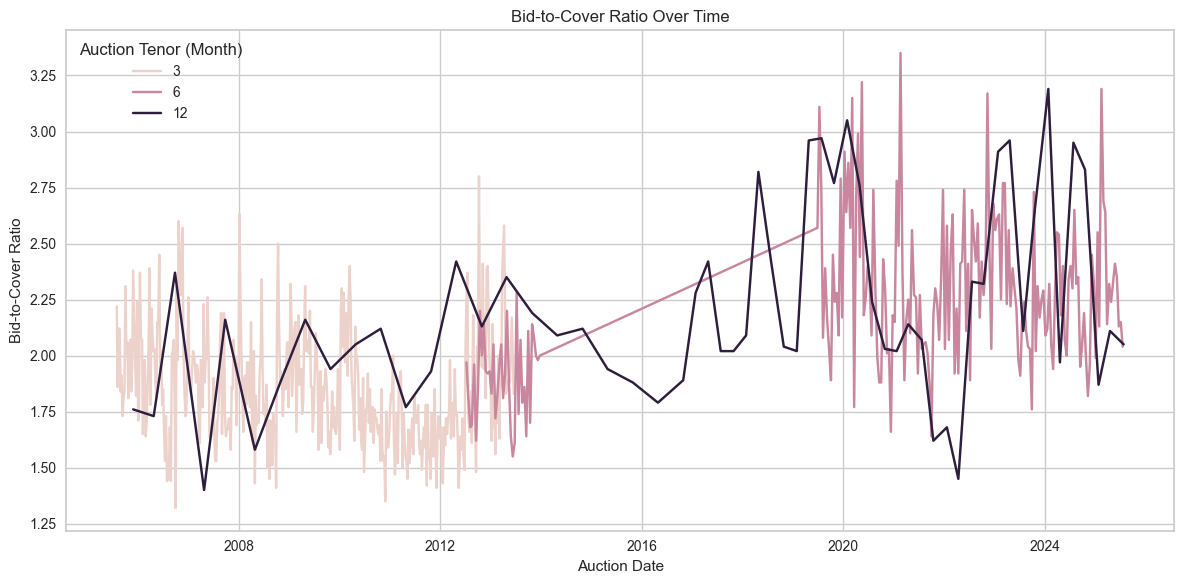

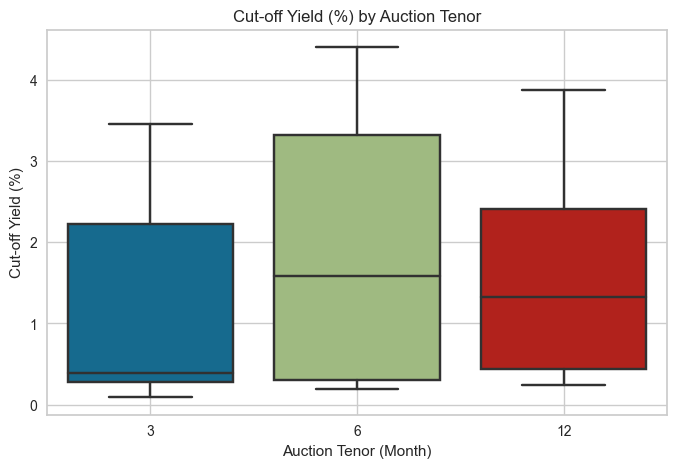

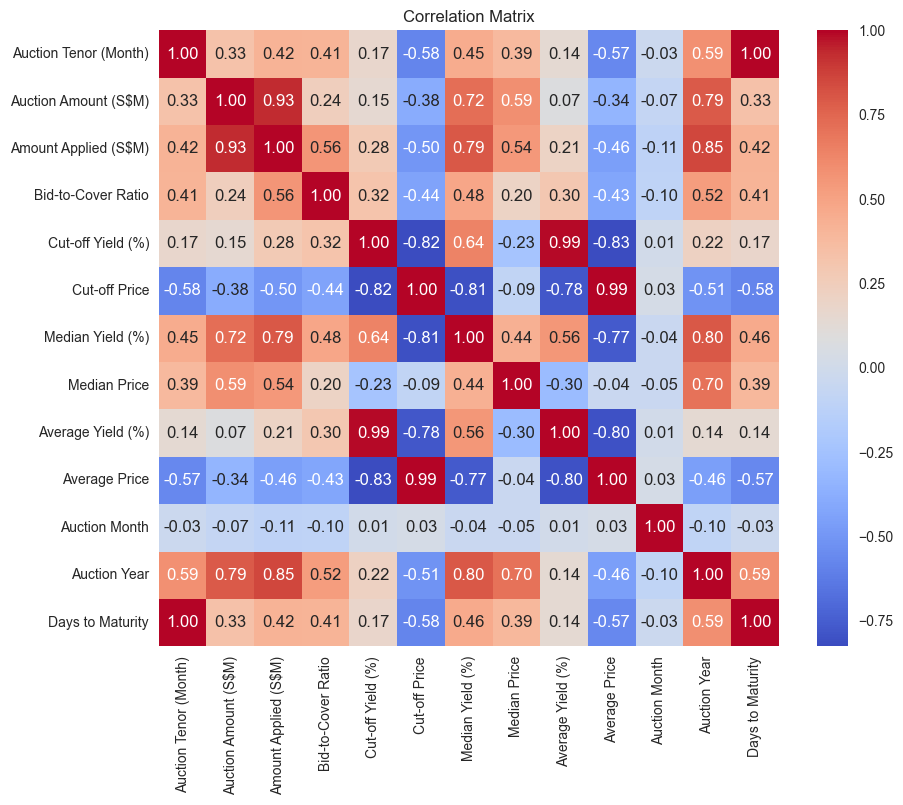

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Plot Cut-off Yield % over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Auction Date", y="Cut-off Yield (%)", hue="Auction Tenor (Month)")
plt.title("Cut-off Yield (%) Over Time")
plt.xlabel("Auction Date")
plt.ylabel("Cut-off Yield (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Bid-to-Cover ratio over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="Auction Date", y="Bid-to-Cover Ratio", hue="Auction Tenor (Month)")
plt.title("Bid-to-Cover Ratio Over Time")
plt.xlabel("Auction Date")
plt.ylabel("Bid-to-Cover Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

# Boxplot of Cut-off Yield by Tenor
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Auction Tenor (Month)", y="Cut-off Yield (%)")
plt.title("Cut-off Yield (%) by Auction Tenor")
plt.grid(True)
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [8]:

# Create features
df['Auction Month'] = df['Auction Date'].dt.month
df['Auction Year'] = df['Auction Date'].dt.year
df['Days to Maturity'] = (df['Maturity Date'] - df['Auction Date']).dt.days

In [9]:
# Features & target
X = df[['Auction Amount (S$M)', 'Auction Month', 'Auction Year', 'Days to Maturity']]
y = df['Cut-off Yield (%)']

# TimeSeriesSplit for temporal validation
tscv = TimeSeriesSplit(n_splits=3)
results = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)

    # XGBoost
    xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)

    # Evaluate
    results.append({
        'Linear_MAE': mean_absolute_error(y_test, y_pred_lr),
        'Linear_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        'XGB_MAE': mean_absolute_error(y_test, y_pred_xgb),
        'XGB_RMSE': np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    })

# Show comparison
result_df = pd.DataFrame(results)
print(result_df)
print("\nAverage Scores:")
print(result_df.mean())


   Linear_MAE  Linear_RMSE   XGB_MAE  XGB_RMSE
0    1.141267     1.284100  1.137884  1.451965
1    1.051176     1.215398  0.242660  0.399693
2    1.213657     1.301694  0.246750  0.372080

Average Scores:
Linear_MAE     1.135367
Linear_RMSE    1.267064
XGB_MAE        0.542431
XGB_RMSE       0.741246
dtype: float64


In [10]:
from pycaret.regression import *

# Reconstruct the dataset with usable features and target
df_model = df.copy()
df_model['Auction Month'] = df_model['Auction Date'].dt.month
df_model['Auction Year'] = df_model['Auction Date'].dt.year
df_model['Days to Maturity'] = (df_model['Maturity Date'] - df_model['Auction Date']).dt.days

# Define the columns not available at prediction time
unavailable_cols = [
    'Amount Applied (S$M)', 'Bid-to-Cover Ratio', 'Cut-off Price',
    'Median Yield (%)', 'Median Price', 'Average Yield (%)', 'Average Price'
]

# Drop them + unnecessary ID/date columns
drop_cols = unavailable_cols + ['Issue Code', 'ISIN Code', 'Auction Date', 'Issue Date', 'Maturity Date']
df_model = df_model.drop(columns=drop_cols)

# Drop rows with missing target
df_model = df_model.dropna(subset=['Cut-off Yield (%)'])


In [11]:
df_model.columns

Index(['Auction Tenor (Month)', 'Auction Amount (S$M)', 'Cut-off Yield (%)',
       'Auction Month', 'Auction Year', 'Days to Maturity'],
      dtype='object')

In [12]:
# Initialize PyCaret regression setup
reg_setup = setup(
    data=df_model,
    target='Cut-off Yield (%)',
    session_id=42,
    # silent=True,
    use_gpu=True  # optional
)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recomp

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with

[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1
[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


,Description,Value
0,Session id,42
1,Target,Cut-off Yield (%)
2,Target type,Regression
3,Original data shape,"(662, 6)"
4,Transformed data shape,"(662, 6)"
5,Transformed train set shape,"(463, 6)"
6,Transformed test set shape,"(199, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.


[LightGBM] [Fatal] GPU Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_GPU=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDA=1


In [13]:
best_model = compare_models()


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0996,0.0323,0.1696,0.9783,0.0716,0.1165,0.0410
et,Extra Trees Regressor,0.1037,0.0350,0.1796,0.9762,0.0787,0.1344,0.0490
rf,Random Forest Regressor,0.1076,0.0416,0.1935,0.9726,0.0809,0.1322,0.0580
gbr,Gradient Boosting Regressor,0.1401,0.0510,0.2195,0.9665,0.0962,0.1902,0.0250
dt,Decision Tree Regressor,0.1152,0.0640,0.2232,0.9584,0.0855,0.1204,0.0050
lightgbm,Light Gradient Boosting Machine,0.1817,0.0840,0.2843,0.9459,0.1106,0.2097,0.0370
ada,AdaBoost Regressor,0.3596,0.1801,0.4209,0.8797,0.2157,0.7365,0.0150
knn,K Neighbors Regressor,0.2644,0.2803,0.5102,0.8231,0.2107,0.3367,0.1840
en,Elastic Net,1.1285,1.5401,1.2379,0.0027,0.5254,2.0637,0.0040
llar,Lasso Least Angle Regression,1.1288,1.5402,1.2379,0.0025,0.5255,2.0660,0.0040


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## Tune the best model

✅ MAE (Mean Absolute Error) — use when:
You want equal treatment of all errors regardless of size.

Outliers should not be heavily penalized.

You prefer robustness to noise or skewed data.

🟢 Use MAE when:

Predicting auction yields with tight tolerances.

You care about average error in absolute terms (e.g. ±0.2%).

✅ RMSE (Root Mean Squared Error) — use when:
You want to penalize large errors more.

Outliers are important and should not be ignored.

You want to highlight large deviations from the actual values.

🔴 Use RMSE when:

Large deviations are costly or unacceptable.

You're optimizing for precision in high-stakes cases (e.g. trading algorithms, risk models).

🧠 In Practice for Yield Prediction:
Since T-bill yields are low and relatively stable, small changes matter.
➡️ MAE might be more appropriate if you're building a forecasting tool for planning purposes.
➡️ RMSE may be better if your model will influence automated decisions or trading logic, where even rare large errors are dangerous.

Recommendation for T-bill yield prediction:

✅ Use MAE for tuning, unless your specific use case penalizes large errors more severely.

In [14]:
tuned_model = tune_model(best_model, optimize='MAE')  # or 'RMSE' depending on your objective


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1948,0.0917,0.3028,0.9417,0.1118,0.1701
1,0.1076,0.0242,0.1556,0.9858,0.0763,0.1471
2,0.1197,0.0446,0.2111,0.9643,0.0858,0.1498
3,0.1333,0.0420,0.2049,0.9791,0.0829,0.1472
4,0.1598,0.0750,0.2738,0.9581,0.1326,0.2930
5,0.1309,0.0597,0.2443,0.9601,0.0863,0.1538
6,0.1116,0.0530,0.2302,0.9623,0.0834,0.1390
7,0.1546,0.0501,0.2239,0.9668,0.1137,0.2418
8,0.1327,0.0384,0.1959,0.9778,0.0836,0.1684


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [15]:
# Finalize the best model
final_model = finalize_model(tuned_model)

# Evaluate with built-in tools
evaluate_model(final_model)

# Predict on the same data or unseen data
predictions = predict_model(final_model)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0249,0.0019,0.0434,0.9988,0.0192,0.0406


In [16]:
save_model(final_model, 'cutoff-yield-app/final-model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Auction Tenor (Month)',
                                              'Auction Amount (S$M)',
                                              'Auction Month', 'Auction Year',
                                              'Days to Maturity'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  Transfo...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               

In [17]:
import gradio as gr
import pandas as pd
from pycaret.regression import predict_model

def predict(
    auction_tenor,
    auction_amount,
    auction_month,
    auction_year,
    days_to_maturity
):
    # Prepare input without target column
    input_df = pd.DataFrame({
        'Auction Tenor (Month)': [auction_tenor],
        'Auction Amount (S$M)': [auction_amount],
        'Auction Month': [auction_month],
        'Auction Year': [auction_year],
        'Days to Maturity': [days_to_maturity]
    })

    preds = predict_model(final_model, data=input_df)

    return float(preds["prediction_label"].iloc[0])  # predicted Cut-off Yield (%)

inputs = [
    gr.Number(label="Auction Tenor (Month)", value=12, precision=0),
    gr.Number(label="Auction Amount (S$M)", value=100.0, precision=2),
    gr.Number(label="Auction Month", value=1, precision=0),
    gr.Number(label="Auction Year", value=2025, precision=0),
    gr.Number(label="Days to Maturity", value=365, precision=0),
]

demo = gr.Interface(
    fn=predict,
    inputs=inputs,
    outputs=gr.Number(label="Predicted Cut-off Yield (%)"),
    title="Cut-off Yield Prediction - Extreme Gradient Boosting",
    description="Disclaimer: This project is for educational and demonstration purposes only. It is not intended to provide investment advice or financial recommendations. The model predictions are based on historical data, and past performance does not guarantee future results. Always consult a licensed financial advisor before making investment decisions."
)

if __name__ == "__main__":
    demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [18]:

import joblib
# from pycaret.regression import load_model, predict_model

model = joblib.load("cutoff-yield-app/final-model.pkl")
# final_model = load_model("cutoff-yield-app/final-model")

def predict(
    auction_tenor,
    auction_amount,
    auction_month,
    auction_year,
    days_to_maturity
):
    # Prepare input without target column
    input_df = pd.DataFrame({
        'Auction Tenor (Month)': [auction_tenor],
        'Auction Amount (S$M)': [auction_amount],
        'Auction Month': [auction_month],
        'Auction Year': [auction_year],
        'Days to Maturity': [days_to_maturity]
    })

    preds = model.predict(input_df)
    print(preds)

    # preds = predict_model(final_model, data=input_df)

    return float(preds[0])  # predicted Cut-off Yield (%)
    return 0.1


inputs = [
    gr.Number(label="Auction Tenor (Month)", value=12, precision=0),
    gr.Number(label="Auction Amount (S$M)", value=100.0, precision=2),
    gr.Number(label="Auction Month", value=1, precision=0),
    gr.Number(label="Auction Year", value=2025, precision=0),
    gr.Number(label="Days to Maturity", value=365, precision=0),
]

demo = gr.Interface(
    fn=predict,
    inputs=inputs,
    outputs=gr.Number(label="Predicted Cut-off Yield (%)"),
    title="Cut-off Yield Prediction - Extreme Gradient Boosting",
    description="Disclaimer: This project is for educational and demonstration purposes only. It is not intended to provide investment advice or financial recommendations. The model predictions are based on historical data, and past performance does not guarantee future results. Always consult a licensed financial advisor before making investment decisions."
)

if __name__ == "__main__":
    demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
